# Дерево решений

In [232]:
class Node:
    def __init__(self, feature = None, threshold = None, left_child = None, right_child = None, *, value = None):
        #feature - критерий разбиения
        #threshold - порог разбиения 
        #left child - нода слева
        #right child - нода справа 
        #value - значение ноды, если она коненчая 
        self.feature = feature
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.value = value
    def is_leaf_node(self):
        #Проверить является ли нода конечным листом
        return self.value is not None

In [233]:
import numpy as np
from collections import Counter
class DecisionTreeClassifier:
    def __init__(self, min_rows_split=2, max_depth=10, number_of_features=None):
        #min_rows_split - минимальнок количетво записей неоюходимых для разбиения 
        #max_depth - максимальная глубина дерева 
        #number_of_features - подмножество критериев для разбиения
        #root - ссылка на корень дерева
        self.min_rows_split = min_rows_split
        self.max_depth = max_depth
        self.number_of_features = number_of_features
        self.root = None
    def _create_tree(self, X, y, depth=0):
        #Количетсво строк и столбцов
        rows, features = X.shape
        #Уникальные проедсказываемые значения y
        labels = len(np.unique(y))
        #Проверка критериев остановки
        if(depth >= self.max_depth or labels == 1 or rows <self.min_rows_split):
            leaf_value = self._most_common_label(y)
            return Node(value = leaf_value)
        #Случайный набор
        feature_indexes = np.random.choice(features, self.number_of_features, replace = False)
        #Найти в этом наборе лучшее свойство для разбиения и лучший порог разбиения
        best_feature, best_threshold = self._best_criteria(X, y, feature_indexes)
        #Разделить
        left_indexes, right_indexes = self._split(X[:, best_feature], best_threshold)
        #Создать ноду слева рекурсивно
        left_child = self._create_tree(X[left_indexes, :], y[left_indexes], depth+1)
        #Создать ноду справа
        right_child = self._create_tree(X[right_indexes, :], y[right_indexes], depth+1)
        return Node(best_feature, best_threshold, left_child, right_child)
    def _best_criteria(self, X, y, feature_indexes):
        #Information gain
        best_gain = -1
        #Свойство и порог дл разбиения 
        split_index, split_threshold = None, None
        #Для каждого свойства
        for feature_index in feature_indexes:
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)
            #Для кажого порога 
            for threshold in thresholds:
                #Подсчитать ig
                gain = self._count_information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold
        return split_index, split_threshold
    def _count_information_gain(self, y, X_column, threshold):
        parent_entropy = self._count_entropy(y)
        left_indexes, right_indexes = self._split(X_column, threshold)
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return 0

        n = len(y)
        left_len, right_len = len(left_indexes), len(right_indexes)
        entropy_left, entropy_right = self._count_entropy(y[left_indexes]), self._count_entropy(y[right_indexes])
        #Энтропия для упорядоченого множества
        child_entropy = (left_len / n) * entropy_left + (right_len / n) * entropy_right

        # Подсчиать ig
        ig = parent_entropy - child_entropy
        return ig
    def _split(self, X_column, threshold):
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        return left_indexes, right_indexes
    def _traverse_tree(self, x, node):
        #Проход по дереву
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left_child)
        return self._traverse_tree(x, node.right_child)
    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    def _count_entropy(self, y):
        #Общее количество записей
        n = len(y)
        #Количетво вхождений неотрицательных значений
        hist = np.bincount(y)
        #Вероятности 
        probabilities = hist / n
        #Энтропия Шенона
        return -np.sum([pi * np.log2(pi) for pi in probabilities if pi > 0])
    def trainDecisionTree(self, X, y):
        self.number_of_features = X.shape[1] if not self.number_of_features else min(self.number_of_features, X.shape[1])
        #Начать построение дерева с корня
        self.root = self._create_tree(X, y)
    def predictDecisionTree(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    def score(self, y_test, y_pred):
        score = np.sum(y_test == y_pred) / len(y_test)
        return score

# Случайный лес

In [84]:
class RandomForest:
    def __init__(self, n_trees=8, min_rows_split=2,
                 max_depth=100, number_of_features=None):
        #Количество деревьев в лесу
        self.n_trees = n_trees
        self.min_rows_split = min_rows_split
        self.max_depth = max_depth
        self.number_of_features = number_of_features
        #Сами деревья
        self.trees = []

    def trainRandomForest(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            #Создать дерево
            tree = DecisionTreeClassifier(min_rows_split=self.min_rows_split,
                max_depth=self.max_depth, number_of_features=self.number_of_features)
            #Разбить выборку
            X_train, y_train = self._random_split(X, y)
            #Построить дерево
            tree.trainDecisionTree(X_train, y_train)
            #Добавить в список деревьев
            self.trees.append(tree)
    def predictRandomForest(self, X):
        #Список предсказаний
        tree_preds = np.array([tree.predictDecisionTree(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        prediction = [self._most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(prediction)
    def _random_split(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    def score(self, y_pred, y_test):
        score = np.sum(y_test == y_pred) / len(y_test)
        return score

# Градиентный бустинг

In [218]:
from sklearn.base import clone
class GradientBoosting():
    def __init__(self, n_estimators=100, learning_rate=0.1, tol=0.5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.tol = tol
        # Основной оценщик
        self.base_estimator = DecisionTreeRegressor(max_depth=10)

    def trainGradientBoosting(self, X, y):
        dtg = DecisionTreeRegressor(max_depth=10)
        self._estimators = [dtg]
        f = dtg.fit(X, y)
        # Начать последовательное построение дерева
        for m in range(self.n_estimators):
            # предсказать, используя все модели, обученных до этой эпохи
            f = self._predict(X)
            # рассчитать остатки от предыдущего шага
            residuals = self._logistic_gradient(y, f)
            # новая модель g для псевдо-остатков
            model = clone(self.base_estimator).fit(X, residuals)
            # Добавить модель к оценщикам, чтобы использовать в прогнозе в след итерации
            self._estimators.append(model)
        return self

    def _predict(self, X):
        # Базовая оценка
        base_score = self._estimators[0].predict(X)
        # Прогнозы скорректированные на скорость обучения
        boosting = np.sum([self.learning_rate * f.predict(X) for f in self._estimators[1:]], axis=0)
        return base_score + boosting

    def _logistic_gradient(self, y, f):
        return y - expit(f)

    def _proba_to_class(self, sample):
        return int(sample > self.tol)

    def predictGradientBoosting(self, X):
        # Прерватить значения в веротяности 0/1
        predicted_probas = expit(self._predict(X))
        # Сложить их в массив
        return np.array([self._proba_to_class(sample) for sample in predicted_probas])
    def predict_proba(self, X):
        return self._predict(X)
    def score(self, y_pred, y_test):
        score = np.sum(y_test == y_pred) / len(y_test)
        return score

# Импорт данных

In [193]:
import pandas as pd
data = pd.read_csv('test.csv', sep=',')
y = data['Visited'].to_numpy()
X = data.drop(columns=['Visited']).to_numpy()

# Разбиение выборки

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)



# Предсказание для дерева решений

In [234]:
tree = DecisionTreeClassifier(max_depth=10)
tree.trainDecisionTree(X_train, y_train)
    
y_pred = tree.predictDecisionTree(X_test)
print(y_pred)
print(tree.score(y_test, y_pred))

[0 0 1 ... 1 0 0]
0.7289772727272728


# Предсказание для случайного леса

In [85]:
forest = RandomForest(n_trees = 5)
forest.trainRandomForest(X_train, y_train)
y_pred = forest.predictRandomForest(X_test)
print(y_pred)
print(forest.score(y_test, y_pred))

[0 0 1 ... 0 1 0]
0.7022727272727273


# Предсказание для градиентного бустинга

[0 0 1 ... 1 0 0]
0.7403409090909091


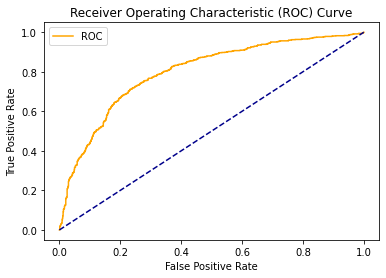

In [219]:
gb = GradientBoosting()
gb.trainGradientBoosting(X_train, y_train)
y_pred = gb.predictGradientBoosting(X_test)

print(y_pred)
print(gb.score(y_test, y_pred))

y_prob = gb.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Ссылка на гх:https://github.com/arsenitem/MLcourse/blob/lab2/lab2.ipynb